In [1]:
import os
os.chdir(path='../..')
import scanpy as sc
import plotly.express as px
from STForte import STGraph
from STForte import STForteModel
from STForte.helper import save_gdata
import plotly.express as px
import matplotlib.pyplot as plt
import STForte.helper as stfhelper

sc.set_figure_params(dpi=120, transparent=True, dpi_save=400, frameon=False, vector_friendly=False, format="pdf")
trial_name = "trial-OSCC/sample_1"
plot_dir = f"./{trial_name}/plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]
palette = px.colors.qualitative.Plotly
color_pallette = px.colors.qualitative.Plotly

lmbd_list = [1]

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Global seed set to 0


In [2]:
adata = sc.read_h5ad(f'data/OSCC/sample_1/sample_1_preprocessed.h5ad')
adata

AnnData object with n_obs × n_vars = 1131 × 15844
    obs: 'pathologist_anno.x', 'sample_id.x', 'cluster_annotations', 'in_tissue', 'row', 'col', 'x', 'y'
    uns: 'pathologist_anno.x_colors', 'spatial'
    obsm: 'spatial'
    layers: 'processed'

In [3]:
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    d=d,
    )
stgraph.pca()
stgraph.padding(reconstruct_knn=True, reconstruct_k=18)
gdata = stgraph.topyg()

d-based initialize:   0%|          | 0/1131 [00:00<?, ?it/s]

PCA pre-compression for data, from 15840 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 7.15s.


brute-force knn initialize:   0%|          | 0/4097 [00:00<?, ?it/s]

FP


In [4]:
for lmbd in lmbd_list:
    model = STForteModel(adata=adata, gdata=gdata,
                     output_dir='./{:s}/pl_ckpts/'.format(trial_name),
                     module_kwargs=dict(hidden_gcns=[100, 50], lmbd_cross=lmbd))
    model.fit()
    model.get_latent_original(adata)
    adata.obsm[f'STForte_COMB_{lmbd}'] = adata.obsm['STForte_COMB']
    adata.obsm[f'STForte_ATTR_{lmbd}'] = adata.obsm['STForte_ATTR']
    adata.obsm[f'STForte_TOPO_{lmbd}'] = adata.obsm['STForte_TOPO'] 

Global seed set to 42
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_c653a0 | 36.8 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.


In [5]:
for lmbd in lmbd_list:
    sc.pp.neighbors(adata, use_rep=f"STForte_ATTR_{lmbd}")
    sc.tl.umap(adata)
    sc.tl.leiden(adata,resolution=0.2, key_added=f"louvain_{lmbd}")

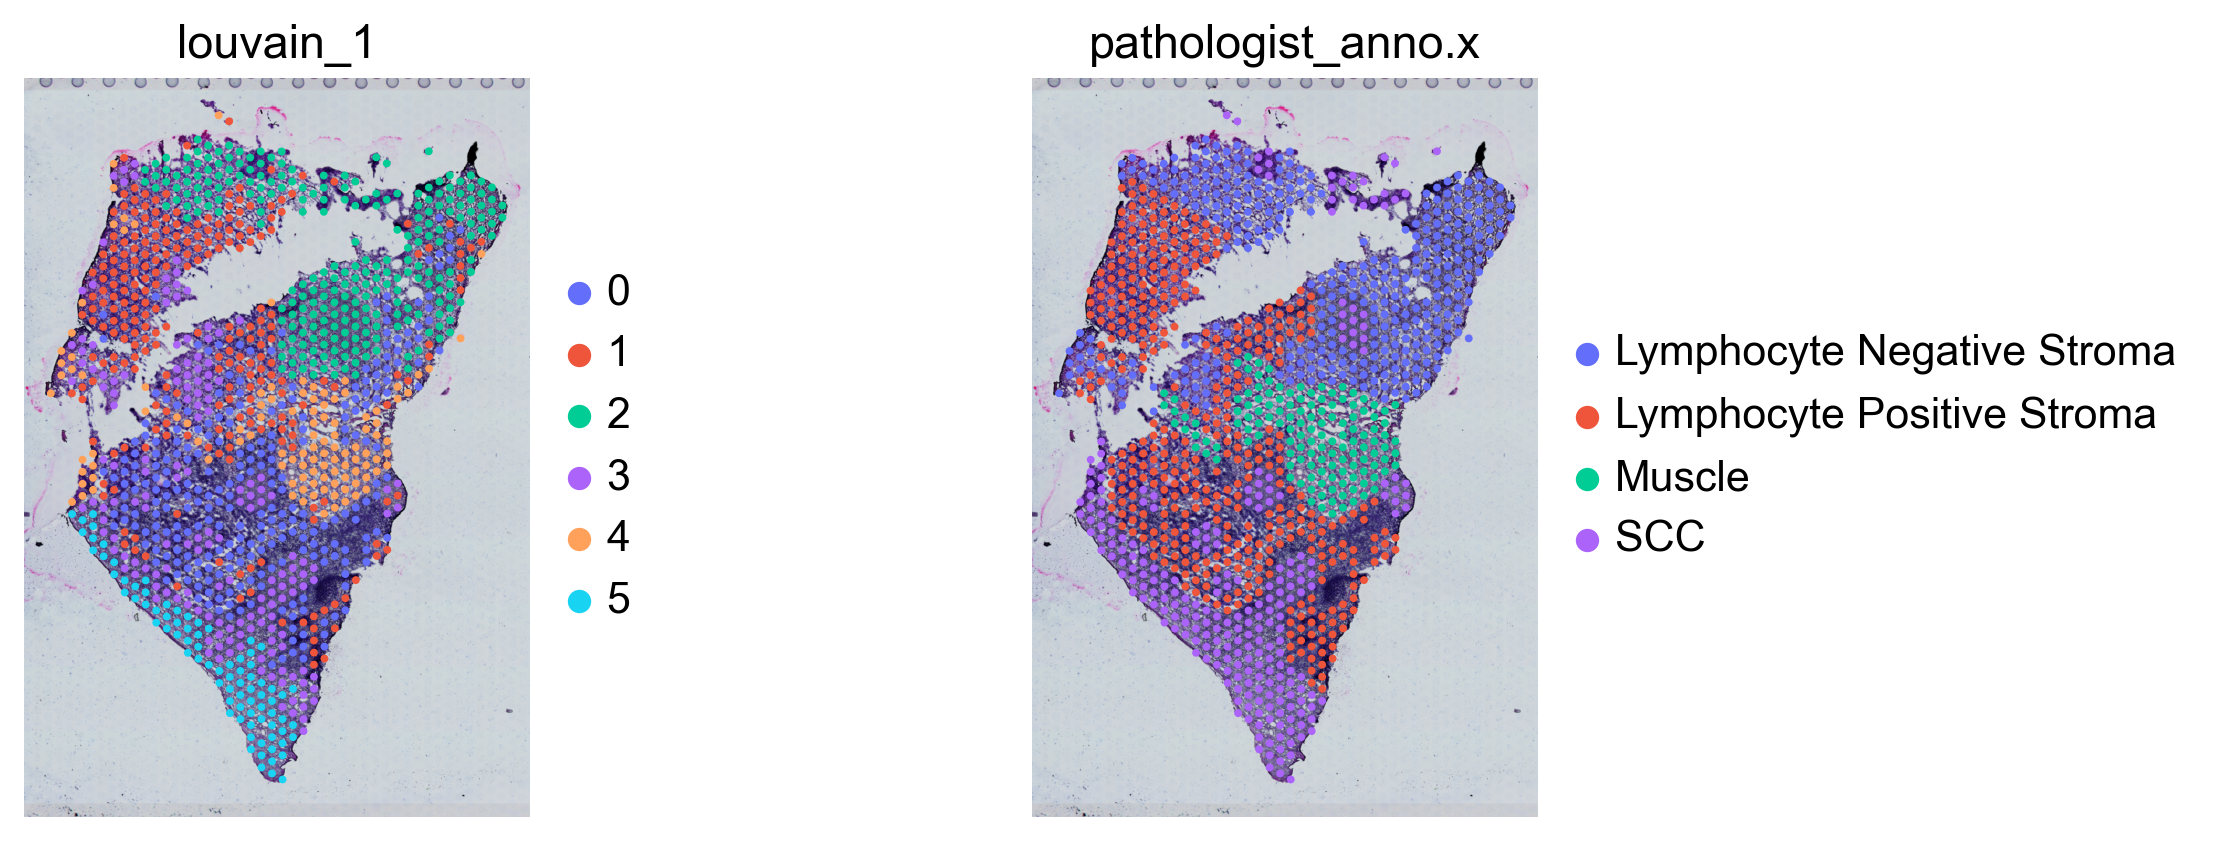

In [6]:
sc.pl.spatial(adata, color=[f"louvain_{i}" for i in lmbd_list]+['pathologist_anno.x'], palette=palette,save=f"lmbd_test_louvain.pdf")

In [8]:
def manual_label(scc: list, normal: list, cluster: iter):
    lable = dict()
    for i in scc:
        lable[i] = "SCC"
    for i in normal:
        lable[i] = 'Normal'
    result = []
    for c in cluster:
        result.append(lable[c])
    return result

In [9]:
adata.obs['STForte_anno_1'] = manual_label(['3','5'],['0','1','2','4'],adata.obs['louvain_1'])
adata.obs['STForte_anno_5'] = manual_label(['4'],['0','1','2','3','5'],adata.obs['louvain_5'])
adata.obs['STForte_anno_10'] = manual_label(['4'],['0','1','2','3','5','6'],adata.obs['louvain_10'])
adata.obs['pathologist_anno'] = manual_label(['SCC'],['Lymphocyte Negative Stroma','Lymphocyte Positive Stroma','Muscle'],adata.obs['pathologist_anno.x'])

In [2]:
adata = sc.read_h5ad("/home/wcx99075523/Experiments/STForte/trial-OSCC/sample_1/outputs/adata_lmbd_demo.h5ad")

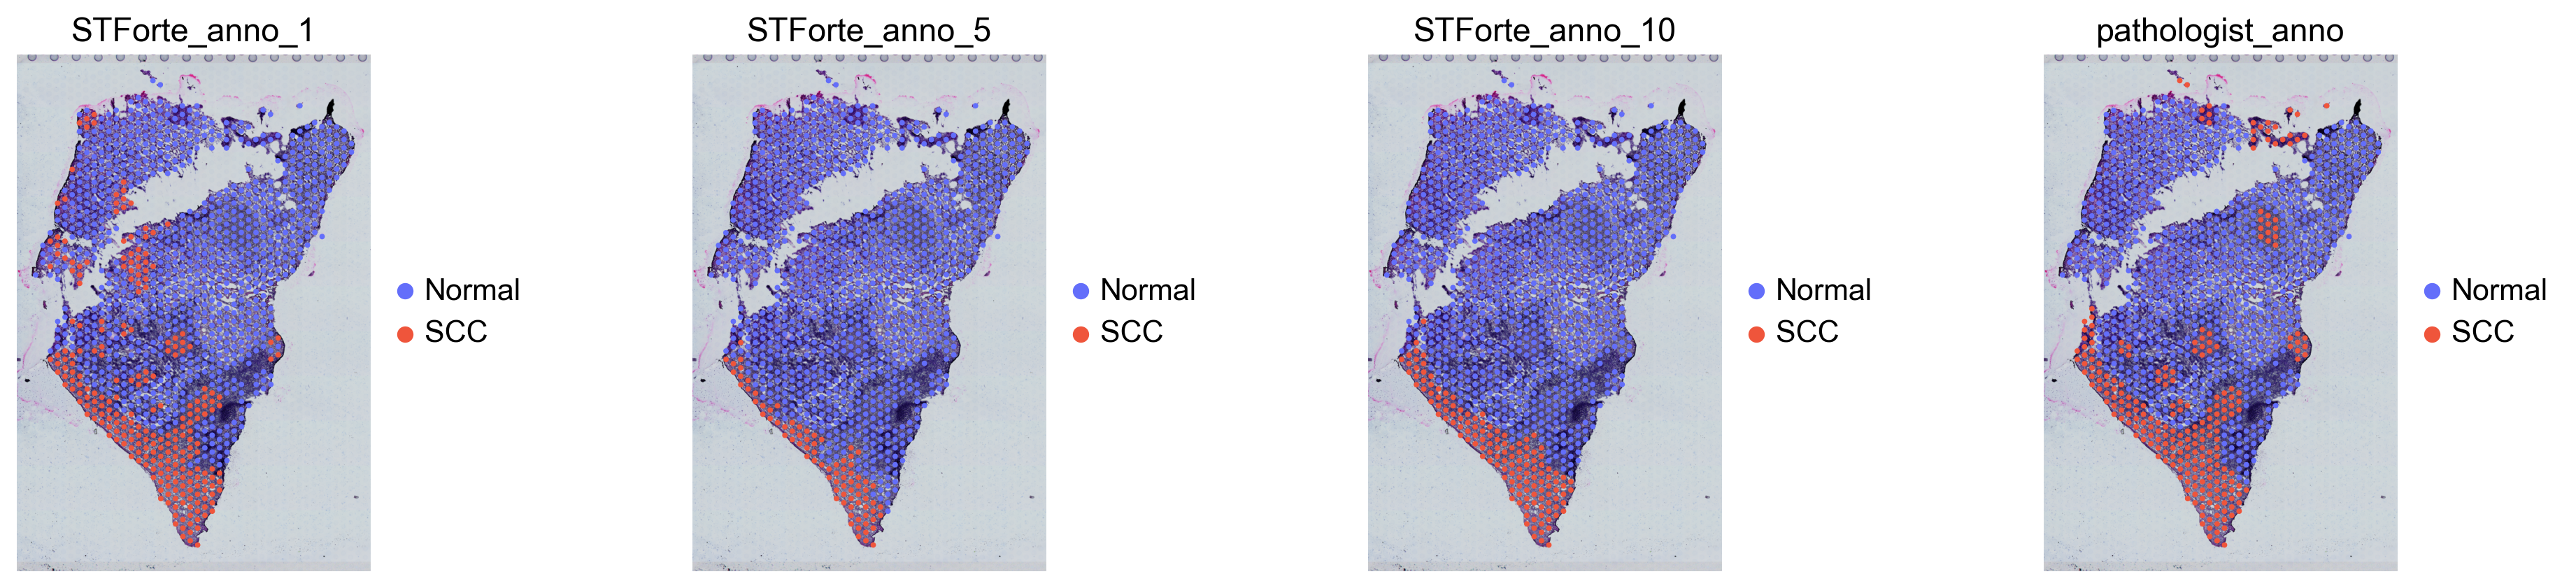

In [3]:
sc.pl.spatial(adata, color=['STForte_anno_1','STForte_anno_5','STForte_anno_10','pathologist_anno'],palette=palette,save="lmbd_test_manual.pdf")

In [16]:
adata.write(f"{trial_name}/outputs/adata_lmbd_demo.h5ad")